# 1. Path Setups

In [4]:
import os
import glob
import cv2 
import time
import base64
import requests
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm
from PIL import Image, ImageDraw, ImageFont, ImageFilter
from roboflow import Roboflow
import json
from Labels import labels
from IPython.display import clear_output
import warnings

warnings.filterwarnings('ignore')

In [3]:
!pip install matplotlib


Defaulting to user installation because normal site-packages is not writeable


In [5]:
ROBOFLOW_API_KEY = "mAx8l6o3PPZKYQReFKQg"
ROBOFLOW_MODEL = "car-plates-jvked/3"
ROBOFLOW_SIZE = 416

In [6]:
paths = {
    'IMAGE_PATH': os.path.join('codes', 'workspace','images'),
 }

# 2. Image Preprocessing and Number Plate Recognition With YOLOv8 From RoboFlow

In [32]:
rf = Roboflow(api_key=ROBOFLOW_API_KEY)
project = rf.workspace().project("car-plates-jvked")
model = project.version(4).model

loading Roboflow workspace...
loading Roboflow project...


In [39]:
ORIGINAL_IMAGE_PATH = os.path.join(paths['IMAGE_PATH'], 'plates', '*ers.jpg')
ORIGINAL_IMAGE_PATH = os.path.join(paths['IMAGE_PATH'], 'plates')
origina_image_paths = list(glob.glob(ORIGINAL_IMAGE_PATH))

In [40]:
IMAGE_PATH = os.path.join(paths['IMAGE_PATH'], 'plates', '*.jpg')
images_path= list(glob.glob(IMAGE_PATH))
# images_path[-3:-1]
# images_path = images_path[-3:-2]
images_path

['codes\\workspace\\images\\plates\\IMG1.jpg',
 'codes\\workspace\\images\\plates\\IMG2.jpg',
 'codes\\workspace\\images\\plates\\IMG3.jpg',
 'codes\\workspace\\images\\plates\\IMG4.jpg',
 'codes\\workspace\\images\\plates\\IMG5.jpg']

In [41]:
print(f'There are {len(images_path):,} images in the plates dataset')

There are 5 images in the plates dataset


5it [00:05,  1.01s/it]


س ق 

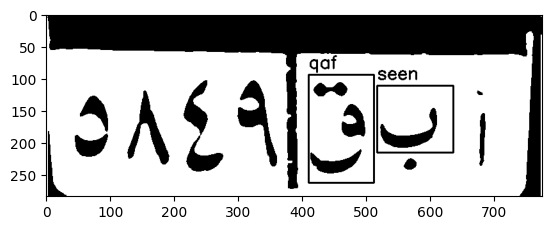

In [42]:
for i, image in tqdm(enumerate(images_path)):
    img = cv2.imread(images_path[i])
    # img_scaled = cv2.resize(img, None, fx=4, fy=4, interpolation = cv2.INTER_LANCZOS4)
    gray_image = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    blur = cv2.GaussianBlur(gray_image, (7,7), 0)

    _, th3 = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)

    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3,3))

    # Apply dilation to thicken the font
    dilated = cv2.dilate(th3, kernel, iterations=1)

    # Apply erosion to shrink the text regions back to their original size
    eroded = cv2.erode(dilated, kernel, iterations=1)


    eroded = cv2.bitwise_not(eroded)


    y_hat= model.predict(eroded, confidence=20, overlap=10).json()
    predictions = y_hat['predictions']


    # sort the predictions based on the `x` coordinate of each bounding box
    predictions_sorted = sorted(predictions, key=lambda x: x['x'],reverse=True)
    for i in range(len(predictions_sorted)):
        x, y, w, h = int(predictions_sorted[i]['x']), int(predictions_sorted[i]['y']), int(predictions_sorted[i]['width']), int(predictions_sorted[i]['height'])
        x_box, y_box = x - w//2, y - h//2 # Calculate the top-left corner of the bounding box
        cv2.rectangle(eroded, (x_box, y_box), (x_box + w, y_box + h), (0, 255, 0), 2)
        class_text = predictions_sorted[i]['class']
        cv2.putText(eroded, class_text, (x_box, y_box-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)

    plt.imshow(eroded,cmap='gray')
for i in range(len(predictions_sorted)):
    print(labels.get(predictions_sorted[i]['class']),end=' ')
    
        

In [38]:
upload_url = "".join([
    "https://detect.roboflow.com/",
    ROBOFLOW_MODEL,
    "?api_key=",
    ROBOFLOW_API_KEY,
    "&format=image",
    "&stroke=5"
])

# Get webcam interface via opencv-python

video = cv2.VideoCapture(0)
video.set(cv2.CAP_PROP_FOURCC, cv2.VideoWriter_fourcc(*"H264"))
# Infer via the Roboflow Infer API and return the result
def infer(video):
    # Get the current image from the webcam
    # video = cv2.VideoCapture(0, cv2.CAP_DSHOW)
    ret, img = video.read()

    # Resize (while maintaining the aspect ratio) to improve speed and save bandwidth
    height, width, channels = img.shape
    scale = ROBOFLOW_SIZE / max(height, width)
    img = cv2.resize(img, (round(scale * width), round(scale * height)))

    # Encode image to base64 string
    retval, buffer = cv2.imencode('.jpg', img)
    img_str = base64.b64encode(buffer)

    # Get prediction from Roboflow Infer API
    resp = requests.post(upload_url, data=img_str, headers={
        "Content-Type": "application/x-www-form-urlencoded"
    }, stream=True).raw

    # Parse result image
    image = np.asarray(bytearray(resp.read()), dtype="uint8")
    image = cv2.imdecode(image, cv2.IMREAD_COLOR)

    return image

# Main loop; infers sequentially until you press "q"
while True:
    start = time.time()
    
    # On "q" keypress, exit
    if cv2.waitKey(1) == ord('q'):
        break
        
    # Synchronously get a prediction from the Roboflow Infer API
    image = infer(video)
    
    # And display the inference results
    cv2.imshow('image', image)
    
    # Sleep for a short time to control the frame rate
    time.sleep(0.05)
    
    # Print frames per second
    print((1/(time.time()-start)), " fps")

# Release resources when finished
video.release()
cv2.destroyAllWindows()


AttributeError: 'NoneType' object has no attribute 'shape'